# Data Cleaning and LASSO

In this notebook, we will apply sophisticated methods to clean the training dataset, and retrain the LASSO model with several L1 penalty rates to aim to improve the model performance.

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer

from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from numpy import mean, std, absolute

import random

In [2]:
# Load data
data_dirpath = 'C:\\Users\\yixin\\Desktop\\Workspace\\Personal GitHub Repos\\House-Prices\\Projects\\House price prediction\\data'

train_csv = pd.read_csv(os.path.join(data_dirpath, "train.csv"))
test_csv = pd.read_csv(os.path.join(data_dirpath, "test.csv"))

In [3]:
train_csv.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
train_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

## Data Cleaning
###### What to clean?
- Outliers: remove them
- Multicollinearity: Remove by LASSO
- Homoscedasity: Adjust the data to make each independent variable homoscedasous
- Missing Value: Fill in with forward or backward fill

### Missing Value imputation



It is crucial to consider how, and what to fill in. As we can see that each features behave differently.<br>

We consider the following approach:

- *Categorical data:* treat missing value (nan) as a separate, independent value, because:

  - Some categorical feature have lots of missing values (e.g.: *PoolQC*), the information is too little to construct a reliable, unbiased imputor. For example, we cannot "guess or predict" what kind of swimming pool a house would have, **a house without a swimming pool shall be considered as a different type**
  - Category are restricted when converted to numerical labels, it does not make sense to predict a "value" for it
  - Avoid artificially generated bias, keep the integrity of data
- *Numerical data*: KNN or multivariate imputor


In [5]:
datatype = dict()

for index, feature in enumerate(train_csv.columns[1:]):
    datatype.setdefault(index + 1,str(train_csv[feature].dtype))

In [6]:
datatype

{1: 'int64',
 2: 'object',
 3: 'float64',
 4: 'int64',
 5: 'object',
 6: 'object',
 7: 'object',
 8: 'object',
 9: 'object',
 10: 'object',
 11: 'object',
 12: 'object',
 13: 'object',
 14: 'object',
 15: 'object',
 16: 'object',
 17: 'int64',
 18: 'int64',
 19: 'int64',
 20: 'int64',
 21: 'object',
 22: 'object',
 23: 'object',
 24: 'object',
 25: 'object',
 26: 'float64',
 27: 'object',
 28: 'object',
 29: 'object',
 30: 'object',
 31: 'object',
 32: 'object',
 33: 'object',
 34: 'int64',
 35: 'object',
 36: 'int64',
 37: 'int64',
 38: 'int64',
 39: 'object',
 40: 'object',
 41: 'object',
 42: 'object',
 43: 'int64',
 44: 'int64',
 45: 'int64',
 46: 'int64',
 47: 'int64',
 48: 'int64',
 49: 'int64',
 50: 'int64',
 51: 'int64',
 52: 'int64',
 53: 'object',
 54: 'int64',
 55: 'object',
 56: 'int64',
 57: 'object',
 58: 'object',
 59: 'float64',
 60: 'object',
 61: 'int64',
 62: 'int64',
 63: 'object',
 64: 'object',
 65: 'object',
 66: 'int64',
 67: 'int64',
 68: 'int64',
 69: 'int64',

In [7]:
label_encoder = LabelEncoder()

for feature in train_csv.columns:
    if train_csv[feature].dtype == "O":
        train_csv[feature] = label_encoder.fit_transform(train_csv[feature])

In [8]:
imp = IterativeImputer(max_iter=100, random_state=0, verbose=True)

train_csv = imp.fit_transform(train_csv)
train_csv = pd.DataFrame(train_csv)

[IterativeImputer] Completing matrix with shape (1460, 81)
[IterativeImputer] Change: 269.4833338211819, scaled tolerance: 755.0 
[IterativeImputer] Early stopping criterion reached.


### Outlier removal

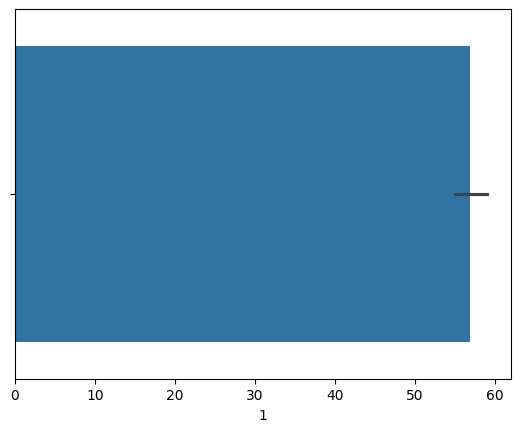

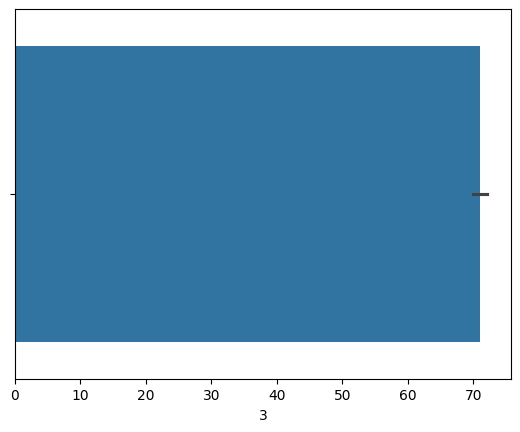

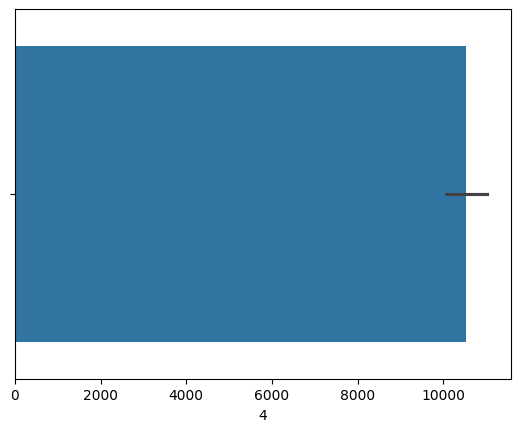

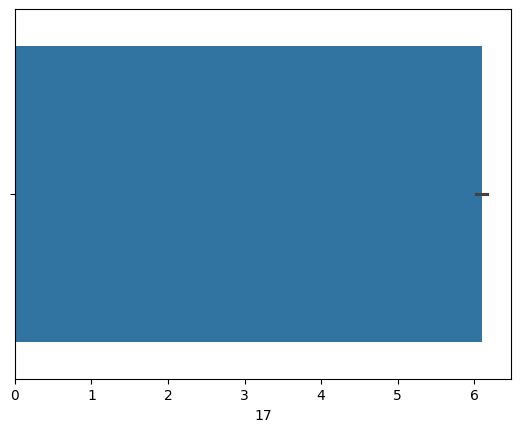

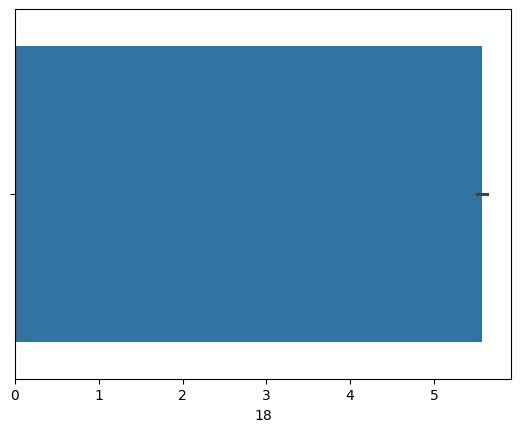

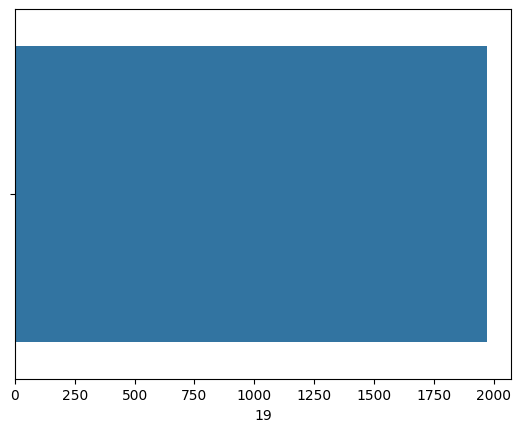

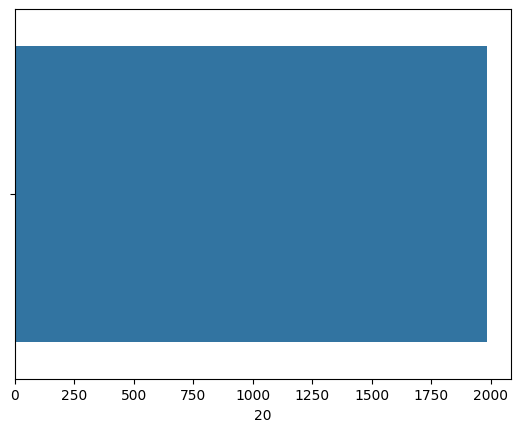

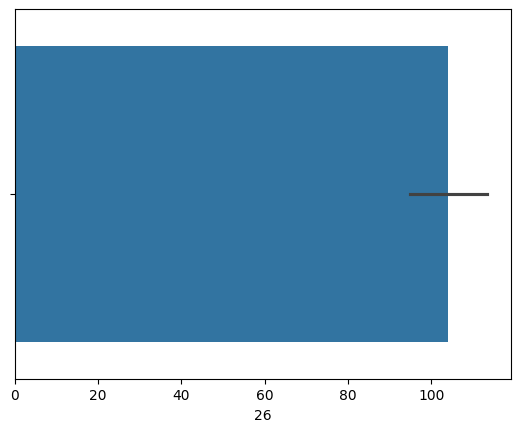

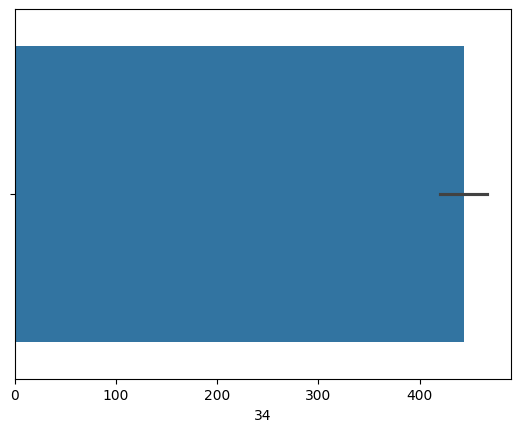

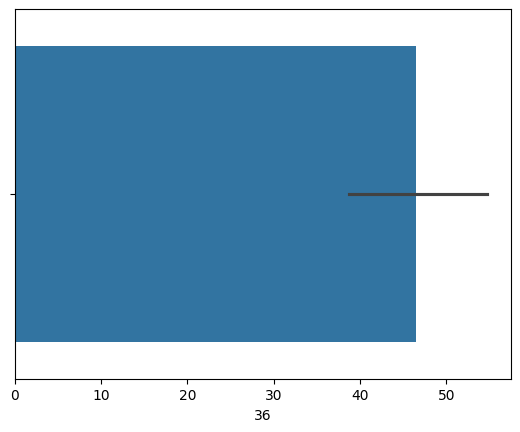

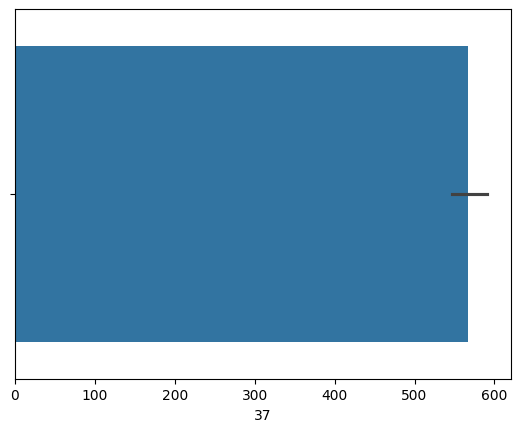

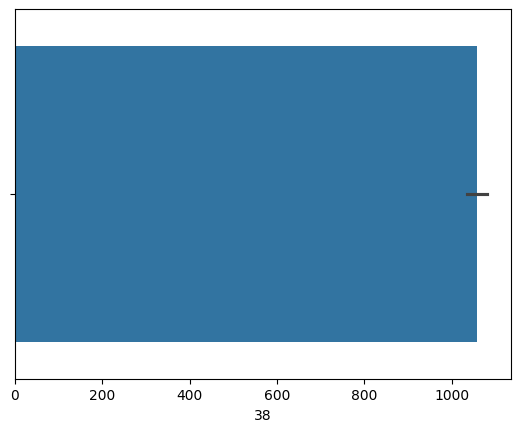

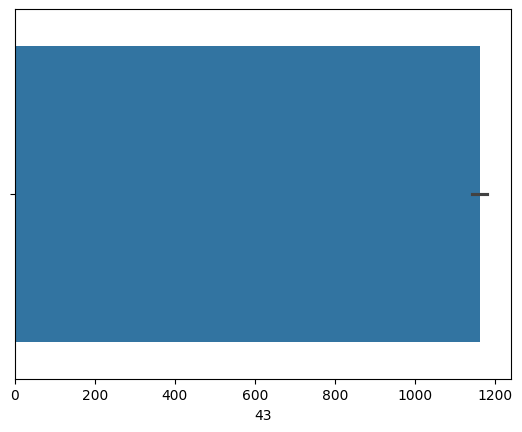

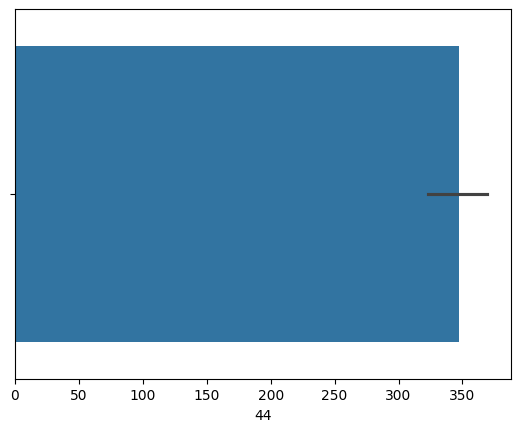

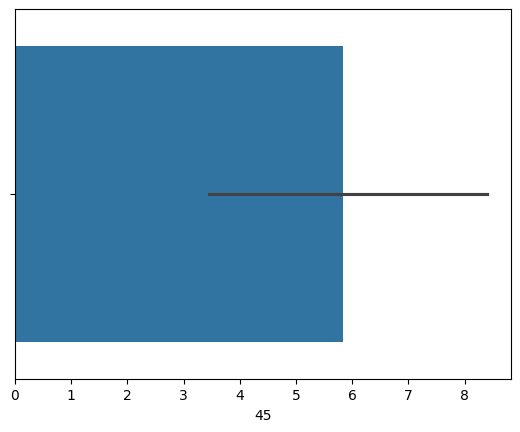

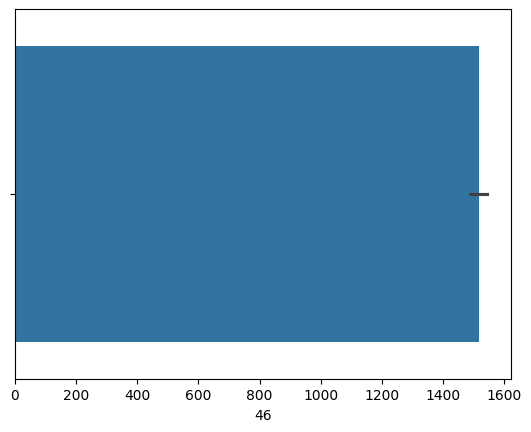

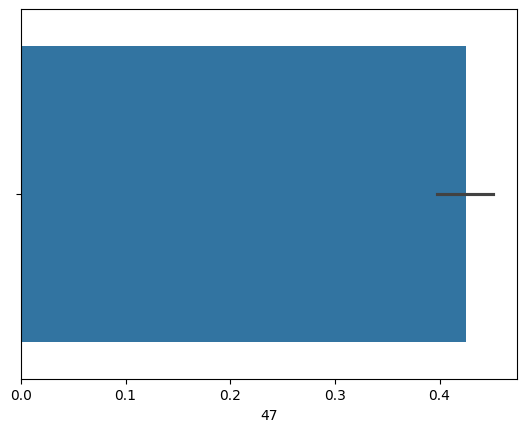

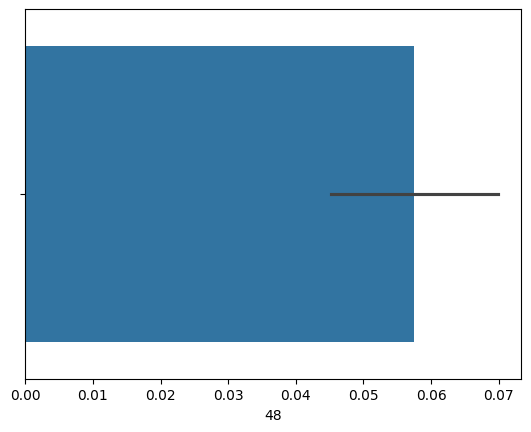

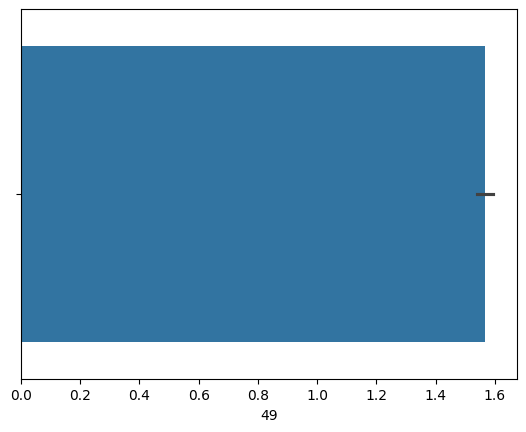

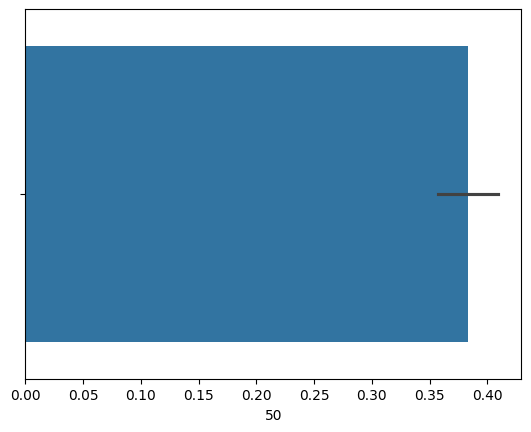

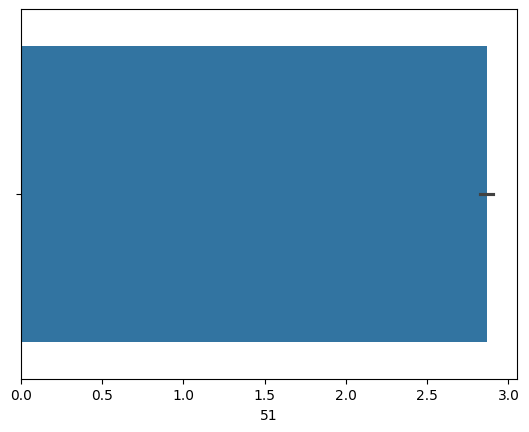

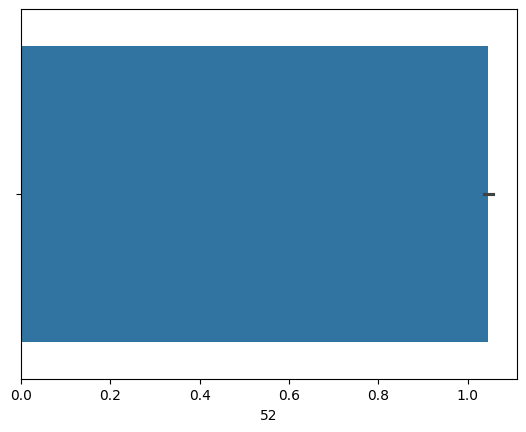

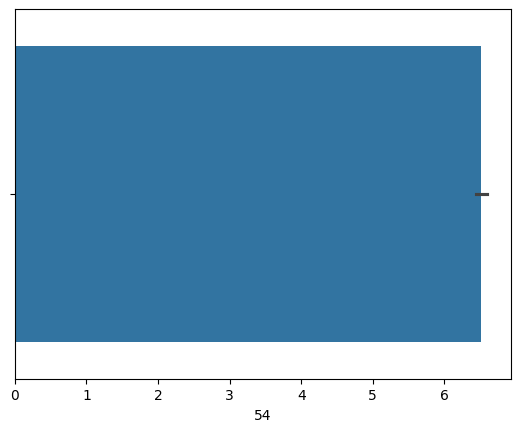

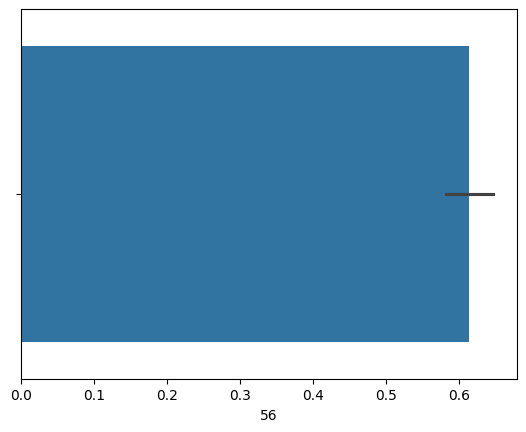

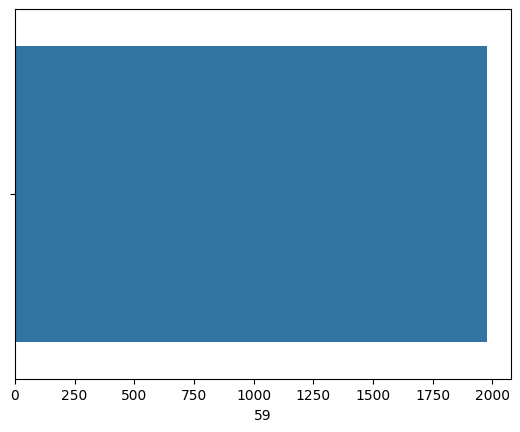

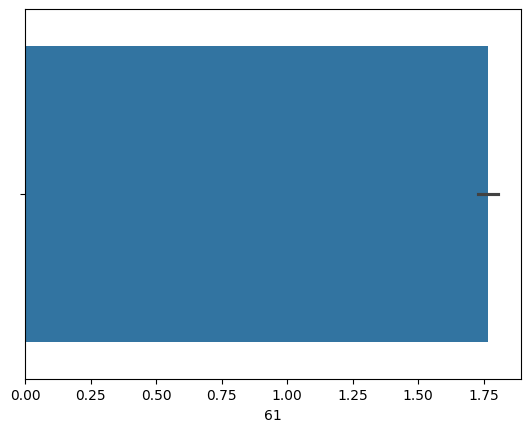

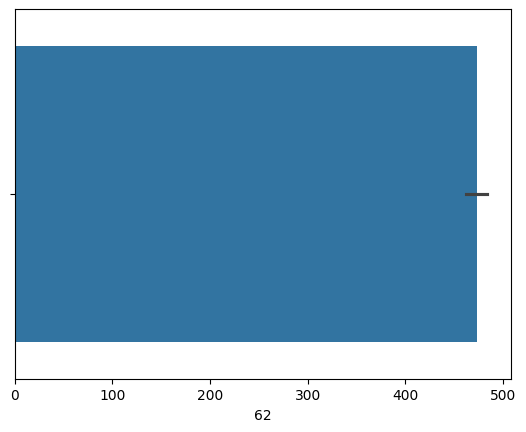

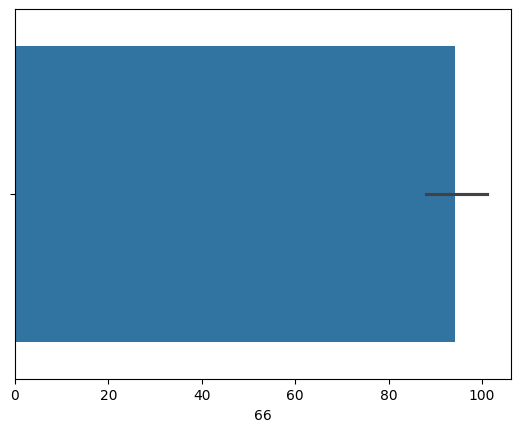

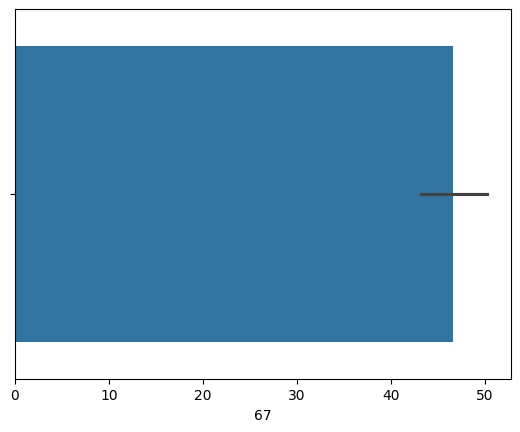

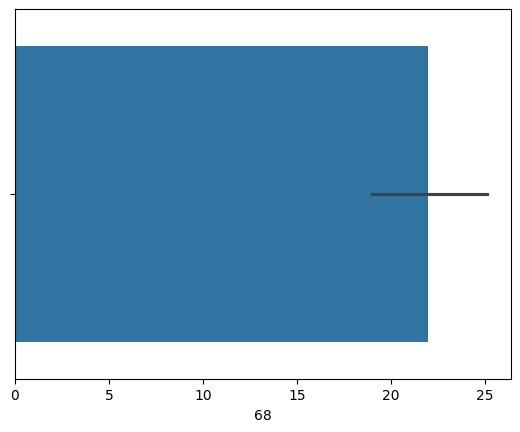

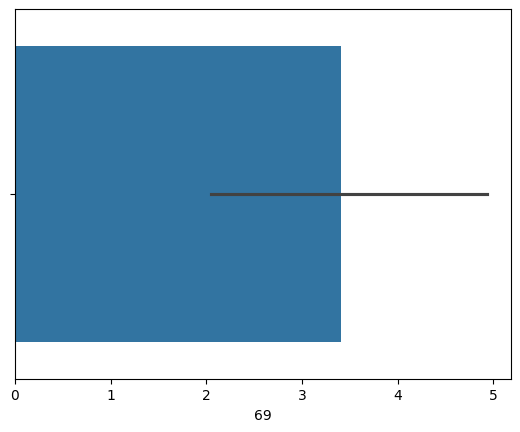

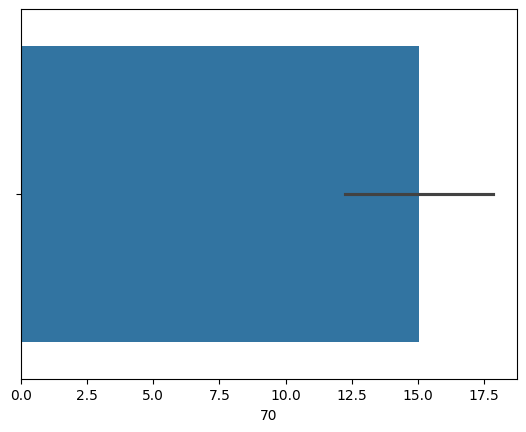

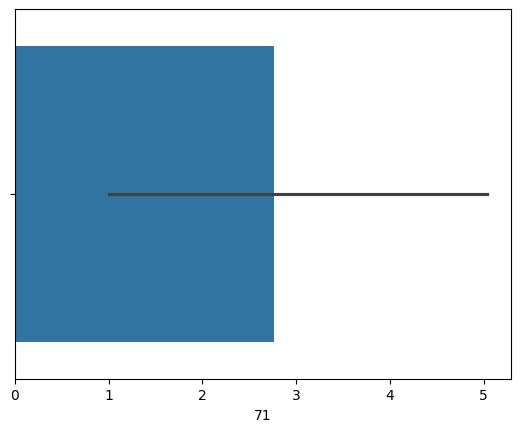

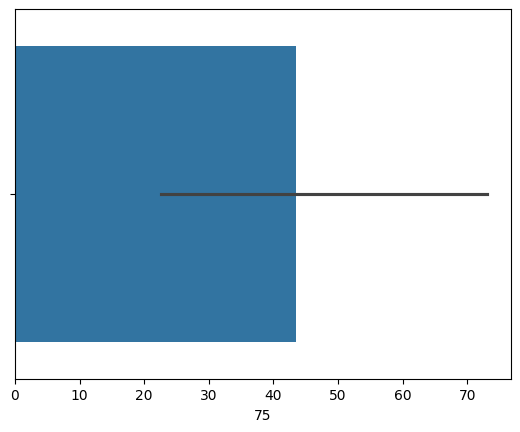

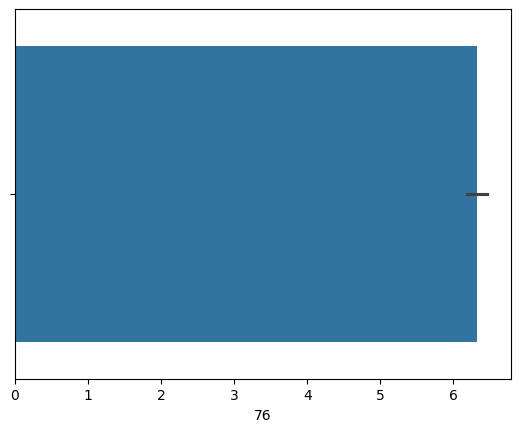

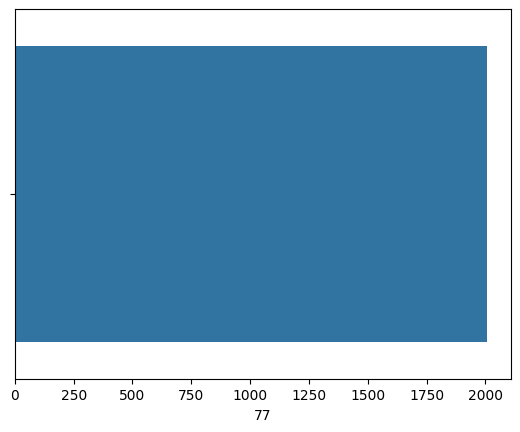

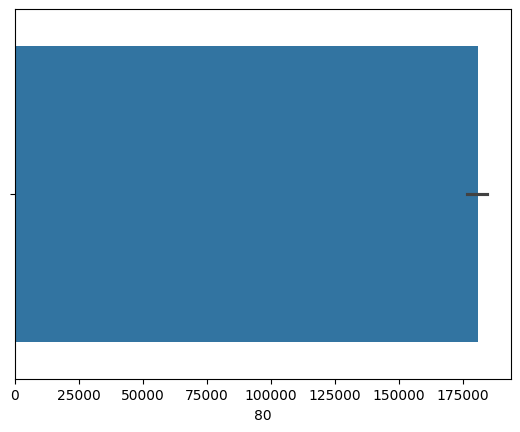

In [9]:
# Display barplot of numerical data

for feature in train_csv.columns[1:]:
    if datatype[feature] != "object":
        sns.barplot(x=feature, data=train_csv)
        plt.show()

In [10]:
# Remove outliers statistically 
# We remove datapoints that stand 3 IQR further than the Q1-Q3 range
# 3 IQR is considered ideal because 1.5 will make too many outliers. 

def detect_outliers(column, df):

    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)

    iqr = q3-q1
    
    outliers = df[(df[column] < (q1-5*iqr)) | (df[column] > (q3+5*iqr))]

    return outliers



In [11]:
# Find the index of rows with outliers and drop them
outlier_index = set()

for feature in train_csv.columns[1:-1]:
    if datatype[feature] != "object":

        for row_index in detect_outliers(feature, train_csv).index:
            outlier_index.add(row_index)

In [12]:
outlier_index

{1,
 3,
 5,
 7,
 8,
 9,
 12,
 14,
 16,
 17,
 21,
 24,
 26,
 29,
 30,
 33,
 37,
 39,
 41,
 42,
 43,
 44,
 46,
 48,
 50,
 51,
 52,
 53,
 55,
 58,
 61,
 63,
 69,
 70,
 72,
 73,
 74,
 77,
 78,
 79,
 80,
 84,
 88,
 92,
 93,
 95,
 98,
 99,
 102,
 104,
 106,
 107,
 108,
 112,
 113,
 114,
 115,
 116,
 120,
 121,
 122,
 125,
 129,
 134,
 137,
 144,
 153,
 154,
 155,
 159,
 164,
 165,
 166,
 170,
 172,
 173,
 174,
 175,
 176,
 177,
 179,
 181,
 182,
 185,
 187,
 188,
 189,
 196,
 197,
 198,
 199,
 201,
 202,
 205,
 207,
 208,
 210,
 213,
 214,
 215,
 217,
 218,
 223,
 230,
 231,
 233,
 237,
 242,
 245,
 246,
 249,
 250,
 251,
 253,
 258,
 260,
 263,
 265,
 267,
 268,
 271,
 273,
 275,
 278,
 280,
 284,
 286,
 289,
 292,
 297,
 298,
 299,
 306,
 312,
 313,
 314,
 318,
 322,
 325,
 328,
 329,
 330,
 332,
 335,
 338,
 339,
 341,
 342,
 344,
 346,
 351,
 352,
 354,
 355,
 358,
 359,
 360,
 362,
 365,
 366,
 367,
 369,
 372,
 373,
 380,
 383,
 384,
 385,
 390,
 392,
 400,
 406,
 407,
 411,
 413,
 414

In [13]:
for feature in train_csv.columns[1:-1]:
    if datatype[feature] != "object":
        print(f"Number of outliers in feature {feature}: {len(detect_outliers(feature,train_csv))}")

Number of outliers in feature 1: 0
Number of outliers in feature 3: 2
Number of outliers in feature 4: 21
Number of outliers in feature 17: 0
Number of outliers in feature 18: 0
Number of outliers in feature 19: 0
Number of outliers in feature 20: 0
Number of outliers in feature 26: 7
Number of outliers in feature 34: 1
Number of outliers in feature 36: 167
Number of outliers in feature 37: 0
Number of outliers in feature 38: 1
Number of outliers in feature 43: 1
Number of outliers in feature 44: 0
Number of outliers in feature 45: 26
Number of outliers in feature 46: 1
Number of outliers in feature 47: 0
Number of outliers in feature 48: 82
Number of outliers in feature 49: 0
Number of outliers in feature 50: 0
Number of outliers in feature 51: 0
Number of outliers in feature 52: 68
Number of outliers in feature 54: 0
Number of outliers in feature 56: 0
Number of outliers in feature 59: 0
Number of outliers in feature 61: 0
Number of outliers in feature 62: 0
Number of outliers in fea

In [14]:
train_csv = train_csv.drop(outlier_index).drop(columns=0)

In [15]:
train_csv

,1,2,3,4,5,6,7,8,9,10,...,71,72,73,74,75,76,77,78,79,80
0,60.0,3.0,65.0,8450.0,1.0,2.0,3.0,3.0,0.0,4.0,...,0.0,3.0,4.0,4.0,0.0,2.0,2008.0,8.0,4.0,208500.0
2,60.0,3.0,68.0,11250.0,1.0,2.0,0.0,3.0,0.0,4.0,...,0.0,3.0,4.0,4.0,0.0,9.0,2008.0,8.0,4.0,223500.0
4,60.0,3.0,84.0,14260.0,1.0,2.0,0.0,3.0,0.0,2.0,...,0.0,3.0,4.0,4.0,0.0,12.0,2008.0,8.0,4.0,250000.0
6,20.0,3.0,75.0,10084.0,1.0,2.0,3.0,3.0,0.0,4.0,...,0.0,3.0,4.0,4.0,0.0,8.0,2007.0,8.0,4.0,307000.0
10,20.0,3.0,70.0,11200.0,1.0,2.0,3.0,3.0,0.0,4.0,...,0.0,3.0,4.0,4.0,0.0,2.0,2008.0,8.0,4.0,129500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,20.0,3.0,78.0,9262.0,1.0,2.0,3.0,3.0,0.0,4.0,...,0.0,3.0,4.0,4.0,0.0,5.0,2009.0,6.0,5.0,287090.0
1452,180.0,4.0,35.0,3675.0,1.0,2.0,3.0,3.0,0.0,4.0,...,0.0,3.0,4.0,4.0,0.0,5.0,2006.0,8.0,4.0,145000.0
1453,20.0,3.0,90.0,17217.0,1.0,2.0,3.0,3.0,0.0,4.0,...,0.0,3.0,4.0,4.0,0.0,7.0,2006.0,8.0,0.0,84500.0
1454,20.0,1.0,62.0,7500.0,1.0,1.0,3.0,3.0,0.0,4.0,...,0.0,3.0,4.0,4.0,0.0,10.0,2009.0,8.0,4.0,185000.0


## LASSO Model
Train the model on data without outliers

Train model with multiple alpha 

In [16]:
X = train_csv.iloc[:,:-1]
Y = train_csv.iloc[:,-1:]


In [17]:
alphas = np.logspace(-4, 0, 50)

result_mean = []
result_std = []
result_alpha= []

for alpha in alphas:

    model = Lasso(alpha=alpha)  

    cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
    # evaluate model
    scores = cross_val_score(model, X, Y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

    print(f'Mean MAE: {mean(scores):.3f} STD: {std(scores):.3f} alpha={alpha}')

    result_mean.append(mean(scores))
    result_std.append(std(scores))
    result_alpha.append(alpha)

print(" ")

print(f"Maximum MAE: {max(result_mean)}, alpha={result_alpha[result_mean.index(max(result_mean))]}")
print(f"Minimum MAE: {min(result_mean)}, alpha={result_alpha[result_mean.index(min(result_mean))]}")

Mean MAE: -17074.782 STD: 1349.613 alpha=0.0001
Mean MAE: -17074.782 STD: 1349.613 alpha=0.00012067926406393288
Mean MAE: -17074.782 STD: 1349.613 alpha=0.00014563484775012445
Mean MAE: -17074.782 STD: 1349.613 alpha=0.00017575106248547912
Mean MAE: -17074.781 STD: 1349.613 alpha=0.00021209508879201905
Mean MAE: -17074.781 STD: 1349.613 alpha=0.0002559547922699536
Mean MAE: -17074.781 STD: 1349.612 alpha=0.00030888435964774815
Mean MAE: -17074.781 STD: 1349.612 alpha=0.0003727593720314938
Mean MAE: -17074.780 STD: 1349.612 alpha=0.0004498432668969444
Mean MAE: -17074.780 STD: 1349.612 alpha=0.0005428675439323859
Mean MAE: -17074.779 STD: 1349.612 alpha=0.0006551285568595509
Mean MAE: -17074.779 STD: 1349.612 alpha=0.0007906043210907702
Mean MAE: -17074.778 STD: 1349.612 alpha=0.0009540954763499944
Mean MAE: -17074.777 STD: 1349.612 alpha=0.0011513953993264468
Mean MAE: -17074.776 STD: 1349.611 alpha=0.0013894954943731374
Mean MAE: -17074.774 STD: 1349.611 alpha=0.0016768329368110067
Me

## Result
###### Removing outliers by 3 IQR: 
The result shows that the performance was increased significantly compared to uncleaned dataset; however, 40% of the datapoints were considered outliers and were removed from the dataset. <br>
It is not sure if the model will perform equally well on the test_csv.

## Next:
1. Try transformation: normalizing data before removing outliers
2. Create scatter plot of residuals to see other potential issues




In [18]:
min_mae = min(result_mean)
best_alpha = result_alpha[result_mean.index(min_mae)]

print(f"Best MAE: {-min_mae:.3f}, alpha={best_alpha}")

# Train the model on the entire dataset using the best alpha
best_model = Lasso(alpha=best_alpha)
best_model.fit(X, Y)

# Step 2: Generate predictions and compute residuals
predictions = best_model.predict(X)
residuals = Y - predictions

# Step 3: Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(predictions, residuals, color='blue', edgecolor='k', alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

Best MAE: 17074.782, alpha=0.0001


ValueError: Unable to coerce to Series, length must be 1: given 855